[View in Colaboratory](https://colab.research.google.com/github/MariamMohamedFawzy/Deep-Learning-Notebooks/blob/master/TGS_Salt_Identification_Challenge_No_Mask_Prediction.ipynb)

# Download the data

In [1]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 235kB 5.7MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
!mkdir .kaggle

In [0]:
!touch .kaggle/kaggle.json

In [4]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!chmod 600 .kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!cp kaggle.json .kaggle/kaggle.json

In [0]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [19]:
!ls

kaggle.json  sample_data


In [12]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 54.9MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 32.0MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 922k/922k [00:00<00:00, 56.8MB/s]
 91%|█████████████████████████████████████▏   | 148M/163M [00:01<00:00, 122MB/s]
100%|█████████████████████████████████████████| 163M/163M [00:01<00:00, 149MB/s]
 61%|███████████████████████               | 23.0M/37.9M [00:00<00:00, 41.3MB/s]
100%|███████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 117MB/s]


In [11]:
!ls

depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv


In [13]:
!unzip train.zip -d train

Archive:  train.zip
   creating: train/images/
   creating: train/masks/
  inflating: train/images/8d08955cdf.png  
  inflating: train/images/e045664b46.png  
  inflating: train/images/4989c6509e.png  
  inflating: train/images/fff4eb4941.png  
  inflating: train/images/3a310860a3.png  
  inflating: train/images/7a696bb878.png  
  inflating: train/images/8d3ee9356b.png  
  inflating: train/images/213e0a9f7b.png  
  inflating: train/images/78f17697f2.png  
  inflating: train/images/bd20d18369.png  
  inflating: train/images/de08c5a3b7.png  
  inflating: train/images/f06ef6c8b7.png  
  inflating: train/images/b2d02516e1.png  
  inflating: train/images/5edb37f5a8.png  
  inflating: train/images/b1f0e104f5.png  
  inflating: train/images/40e8e14e60.png  
  inflating: train/images/6e1444d88d.png  
  inflating: train/images/f342603c76.png  
  inflating: train/images/7ba58ee1be.png  
  inflating: train/images/14a89a1840.png  
  inflating: train/images/4319885cf1.png  
  inflating: train/image

# Drive

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def upload_file(file_name):
  uploaded = drive.CreateFile({'title': file_name})
  uploaded.SetContentFile(file_name)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
def download_file(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(file_name)

# Import libraries

In [21]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.19.2)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import cv2

In [0]:
from sklearn.model_selection import train_test_split

In [9]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2

Using TensorFlow backend.


In [0]:
import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Flatten, Conv1D

In [0]:
from keras import backend as K

# Explore the data

In [0]:
depths = pd.read_csv('depths.csv')

In [113]:
depths.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


In [114]:
depths.describe()

,z
count,22000.000000
mean,506.453318
std,208.605991
min,50.000000
25%,352.000000
50%,513.000000
75%,671.000000
max,959.000000


(array([1076., 1470., 2127., 2761., 3223., 3345., 3029., 2611., 1879.,
         479.]),
 array([ 50. , 140.9, 231.8, 322.7, 413.6, 504.5, 595.4, 686.3, 777.2,
        868.1, 959. ]),
 <a list of 10 Patch objects>)

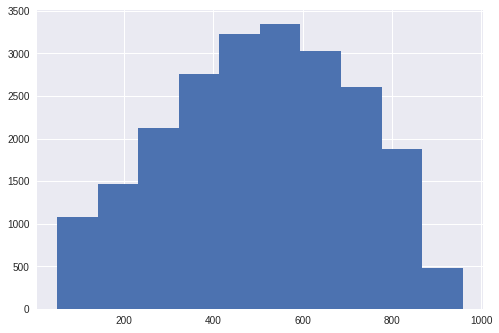

In [115]:
plt.hist(depths.z)

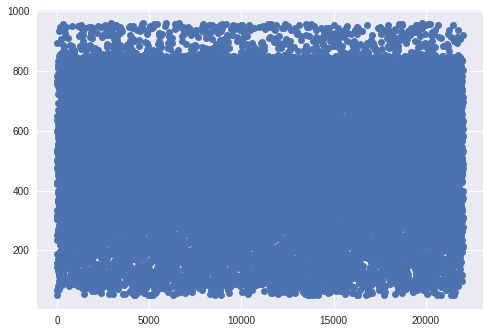

In [116]:
plt.plot(range(depths.shape[0]), depths.z, 'o')

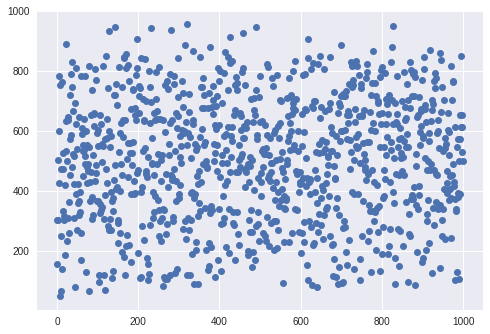

In [117]:
plt.plot(range(1000), depths.z[:1000], 'o')

In [0]:
train_csv = pd.read_csv('train.csv')

In [14]:
train_csv.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [120]:
np.sum(train_csv.rle_mask.isna()) , train_csv.shape[0]

(1562, 4000)

In [0]:
ids = train_csv.id.tolist()

In [0]:
images = np.array(list(map(lambda x: cv2.imread('./train/images/'+ x + '.png'), ids)))

In [0]:
masks = np.array(list(map(lambda x: cv2.imread('./train/masks/'+ x + '.png'), ids)))

In [13]:
images.shape

(4000, 101, 101, 3)

In [127]:
masks.shape

(4000, 101, 101, 3)

In [0]:
def show_image_mask(ind):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(images[ind])
  ax2.imshow(masks[ind])

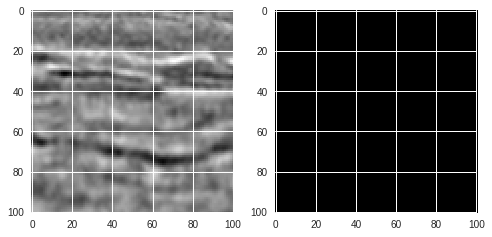

In [129]:
show_image_mask(0)

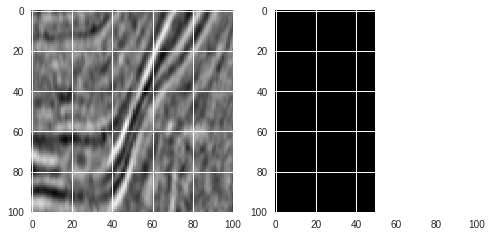

In [140]:
show_image_mask(1)

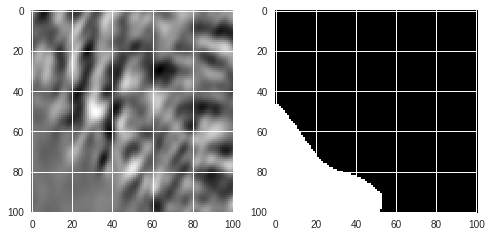

In [141]:
show_image_mask(3)

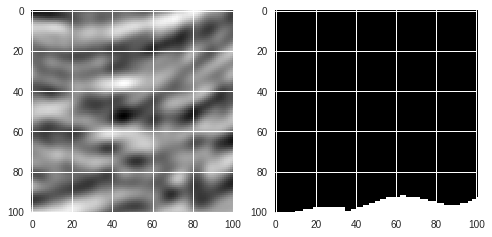

In [132]:
show_image_mask(4)

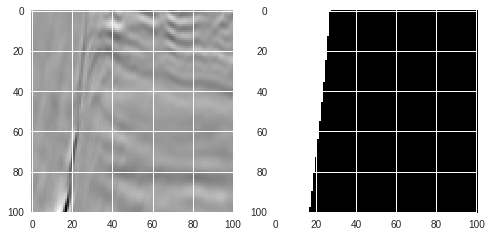

In [133]:
show_image_mask(5)

In [0]:
nan_ids = train_csv[train_csv.rle_mask.isna()].id

In [0]:
nan_ids = nan_ids.tolist()

In [0]:
def plot_nan_mask(ind):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(cv2.imread('./train/images/'+ nan_ids[1] + '.png', 0))
  ax2.imshow(cv2.imread('./train/masks/'+ nan_ids[1] + '.png', 0))

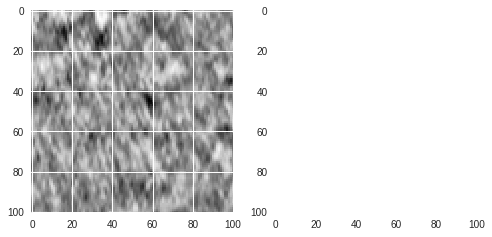

In [137]:
plot_nan_mask(10)

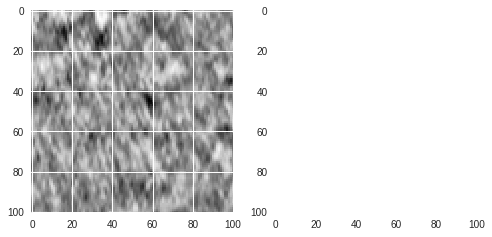

In [138]:
plot_nan_mask(90)

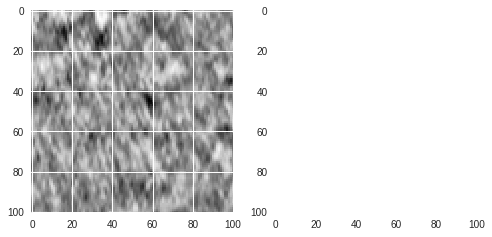

In [139]:
plot_nan_mask(1)

In [0]:
rle_mask = train_csv.rle_mask.isna()

In [144]:
rle_mask.head()

0     True
1    False
2    False
3    False
4    False
Name: rle_mask, dtype: bool

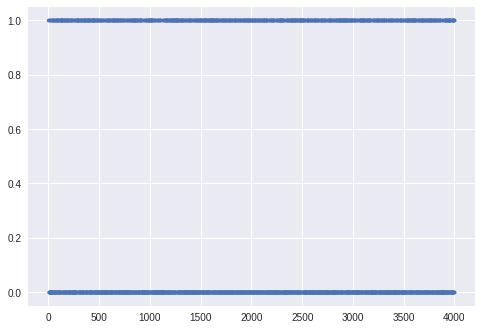

In [149]:
plt.plot(range(rle_mask.shape[0]), rle_mask, '.')

# Build binary classifier (Nan or not)

# Split the data

In [14]:
images.shape

(4000, 101, 101, 3)

In [0]:
images = np.array(list(map(lambda x: cv2.resize(x, (299, 299)), images)))

In [16]:
images.shape

(4000, 299, 299, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images, rle_mask, test_size=0.2, random_state=42)

# Build the model

# VGG

In [0]:
vgg = VGG16(weights='imagenet', include_top=False)

In [39]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [15]:

input = Input(shape=(299, 299, 3))

last_conv = vgg(input)

x = Flatten(name='flatten')(last_conv)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(input=input, output=x)

my_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              84936704  
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
predictions (Dense)          (None, 1)                 1025      
Total params: 101,750,593
Trainable params: 101,750,593
Non-trainable params: 0
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  # This is added back by InteractiveShellApp.init_path()


In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [0]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
my_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=45,
    horizontal_flip=True,
    vertical_flip=True)


datagen.fit(X_train)


In [19]:
# fits the model on batches with real-time data augmentation:
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=50)

Epoch 1/50
100/100 [==============================] - 100s 998ms/step - loss: 1.0135 - acc: 0.6278
Epoch 2/50
100/100 [==============================] - 92s 918ms/step - loss: 0.7978 - acc: 0.7228
Epoch 3/50
100/100 [==============================] - 89s 886ms/step - loss: 0.7639 - acc: 0.7212
Epoch 4/50
100/100 [==============================] - 92s 917ms/step - loss: 0.6677 - acc: 0.7566
Epoch 5/50
100/100 [==============================] - 92s 924ms/step - loss: 0.6310 - acc: 0.7741
Epoch 6/50
100/100 [==============================] - 92s 924ms/step - loss: 0.6273 - acc: 0.7725
Epoch 7/50
100/100 [==============================] - 90s 904ms/step - loss: 0.5829 - acc: 0.7887
Epoch 8/50
100/100 [==============================] - 88s 881ms/step - loss: 0.5822 - acc: 0.7816
Epoch 9/50
100/100 [==============================] - 90s 901ms/step - loss: 0.5707 - acc: 0.7812
Epoch 10/50
100/100 [==============================] - 95s 947ms/step - loss: 0.5844 - acc: 0.7772
Epoch 11/50
100/10

In [20]:
my_model.evaluate(X_test, y_test)

800/800 [==============================] - 14s 17ms/step


[0.3413389927148819, 0.845]

In [21]:
# fits the model on batches with real-time data augmentation:
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=50)

Epoch 1/50
100/100 [==============================] - 95s 948ms/step - loss: 0.3914 - acc: 0.8291
Epoch 2/50
100/100 [==============================] - 93s 932ms/step - loss: 0.4086 - acc: 0.8291
Epoch 3/50
100/100 [==============================] - 91s 908ms/step - loss: 0.3914 - acc: 0.8394
Epoch 4/50
100/100 [==============================] - 88s 884ms/step - loss: 0.4105 - acc: 0.8334
Epoch 5/50
100/100 [==============================] - 94s 937ms/step - loss: 0.4273 - acc: 0.8266
Epoch 6/50
100/100 [==============================] - 92s 921ms/step - loss: 0.4089 - acc: 0.8303
Epoch 7/50
100/100 [==============================] - 92s 917ms/step - loss: 0.4049 - acc: 0.8309
Epoch 8/50
100/100 [==============================] - 88s 881ms/step - loss: 0.3960 - acc: 0.8278
Epoch 9/50
100/100 [==============================] - 89s 887ms/step - loss: 0.3992 - acc: 0.8369
Epoch 10/50
100/100 [==============================] - 94s 936ms/step - loss: 0.3799 - acc: 0.8387
Epoch 11/50
100/100

In [22]:
my_model.evaluate(X_test, y_test)

800/800 [==============================] - 14s 18ms/step


[0.3281931585073471, 0.85375]

# Part of VGG

In [0]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [34]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [18]:
# input = Input(shape=(299, 299, 3))


layers = dict([(layer.name, layer) for layer in vgg.layers])

vgg_top = layers['block5_conv2'].output

x = Flatten(name='flatten')(vgg_top)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(512, activation='relu', name='fc3')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(input=vgg.input, output=x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  del sys.path[0]


In [18]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [0]:
sgd = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
my_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=45,
    horizontal_flip=True,
    vertical_flip=True)


datagen.fit(X_train)


In [23]:
# history = my_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
# fits the model on batches with real-time data augmentation:
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=50)

Epoch 1/50
100/100 [==============================] - 102s 1s/step - loss: 4.5398 - acc: 0.6741
Epoch 2/50
100/100 [==============================] - 100s 1000ms/step - loss: 4.4221 - acc: 0.7028
Epoch 3/50
100/100 [==============================] - 100s 999ms/step - loss: 4.0211 - acc: 0.7331
Epoch 4/50
100/100 [==============================] - 100s 1s/step - loss: 3.3391 - acc: 0.7675
Epoch 5/50
100/100 [==============================] - 100s 1s/step - loss: 3.3805 - acc: 0.7550
Epoch 6/50
100/100 [==============================] - 101s 1s/step - loss: 2.4874 - acc: 0.7781
Epoch 7/50
100/100 [==============================] - 105s 1s/step - loss: 1.0310 - acc: 0.7644
Epoch 8/50
100/100 [==============================] - 101s 1s/step - loss: 0.6099 - acc: 0.7875
Epoch 9/50
100/100 [==============================] - 101s 1s/step - loss: 0.4903 - acc: 0.8050
Epoch 10/50
100/100 [==============================] - 100s 1s/step - loss: 0.4793 - acc: 0.7984
Epoch 11/50
100/100 [===========

In [24]:
my_model.evaluate(X_test, y_test)

800/800 [==============================] - 17s 22ms/step


[0.2798808920383453, 0.88375]

In [0]:
my_model.save_weights('part_vgg_50.h5')

In [0]:
my_model.load_weights('part_vgg_50.h5')

In [28]:
# history = my_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
# fits the model on batches with real-time data augmentation:
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=25)

Epoch 1/25
100/100 [==============================] - 102s 1s/step - loss: 0.3077 - acc: 0.8659
Epoch 2/25
100/100 [==============================] - 98s 984ms/step - loss: 0.3051 - acc: 0.8653
Epoch 3/25
100/100 [==============================] - 98s 983ms/step - loss: 0.3030 - acc: 0.8659
Epoch 4/25
100/100 [==============================] - 98s 979ms/step - loss: 0.3057 - acc: 0.8659
Epoch 5/25
100/100 [==============================] - 98s 979ms/step - loss: 0.2949 - acc: 0.8688
Epoch 6/25
100/100 [==============================] - 96s 961ms/step - loss: 0.3099 - acc: 0.8594
Epoch 7/25
100/100 [==============================] - 97s 970ms/step - loss: 0.3036 - acc: 0.8675
Epoch 8/25
100/100 [==============================] - 97s 969ms/step - loss: 0.3035 - acc: 0.8681
Epoch 9/25
100/100 [==============================] - 98s 975ms/step - loss: 0.2972 - acc: 0.8678
Epoch 10/25
100/100 [==============================] - 97s 969ms/step - loss: 0.2991 - acc: 0.8666
Epoch 11/25
100/100 [

In [29]:
my_model.evaluate(X_test, y_test)

800/800 [==============================] - 15s 19ms/step


[0.269577317237854, 0.89125]

In [0]:
my_model.save_weights('part_vgg_75.h5')

In [37]:
upload_file('part_vgg_75.h5')

Uploaded file with ID 1Bgxt2D25HgLuzK5UPg6FxJ87Cy7X9hjr


In [0]:
download_file('part_vgg_75.h5', '1Bgxt2D25HgLuzK5UPg6FxJ87Cy7X9hjr')

In [0]:
my_model.load_weights('part_vgg_75.h5')

**reduce learning rate for part VGG**

In [45]:
K.eval(my_model.optimizer.lr)

1e-04

In [46]:
K.eval(my_model.optimizer.lr.assign(0.00001))

1e-05

In [47]:
my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=25)

Epoch 1/25
100/100 [==============================] - 114s 1s/step - loss: 0.2710 - acc: 0.8828
Epoch 2/25
100/100 [==============================] - 105s 1s/step - loss: 0.2675 - acc: 0.8850
Epoch 3/25
100/100 [==============================] - 105s 1s/step - loss: 0.2778 - acc: 0.8825
Epoch 4/25
100/100 [==============================] - 104s 1s/step - loss: 0.2648 - acc: 0.8931
Epoch 5/25
100/100 [==============================] - 102s 1s/step - loss: 0.2693 - acc: 0.8838
Epoch 6/25
100/100 [==============================] - 102s 1s/step - loss: 0.2690 - acc: 0.8831
Epoch 7/25
100/100 [==============================] - 96s 964ms/step - loss: 0.2538 - acc: 0.8881
Epoch 8/25
100/100 [==============================] - 96s 963ms/step - loss: 0.2565 - acc: 0.8812
Epoch 9/25
100/100 [==============================] - 99s 993ms/step - loss: 0.2646 - acc: 0.8806
Epoch 10/25
100/100 [==============================] - 97s 970ms/step - loss: 0.2632 - acc: 0.8831
Epoch 11/25
100/100 [==========

In [48]:
my_model.evaluate(X_test, y_test)

800/800 [==============================] - 15s 18ms/step


[0.2573054265975952, 0.895]

In [0]:
my_model.save_weights('part_vgg_100.h5')

In [50]:
upload_file('part_vgg_100.h5')

Uploaded file with ID 1vZXbl5hVWTpK6R7fgeg82yAWAs3kAm0z


**reducing learning rate was not so good**

In [0]:
# my_model.load_weights('part_vgg_100.h5')

In [0]:
# K.eval(my_model.optimizer.lr.assign(0.0001))

In [0]:
# my_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
#                     steps_per_epoch=len(X_train) / 32, epochs=25)